In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from data_processing import *
import data_processing as dp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATADIR = Path('data')

In [3]:
print(os.listdir(DATADIR))

['df_location_ratio.csv', '.DS_Store', 'df_phq9.csv', 'df_phq2_v2.csv', 'df_baseline_phq9.csv', 'df_passive_mobility_features.csv', 'df_demographics.csv', 'data_analysis.ipynb']


# Preparing the Data for Training

## Reading the Data

In [4]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,phq9Date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0


In [5]:
demographics = pd.read_csv(DATADIR / 'df_demographics.csv')
demographics.head()

,Unnamed: 0,participant_id,working,income_satisfaction,income_lastyear,age,startdate,study,gen_Female,gen_Male,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,213,EN00033,1.0,3.0,6.0,52.0,2016-08-12 12:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
1,214,EN00034,1.0,3.0,4.0,32.0,2016-08-12 12:58:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
2,215,EN00035,0.0,2.0,2.0,57.0,2016-08-12 15:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
3,216,EN00036,1.0,3.0,3.0,55.0,2016-08-13 10:24:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
4,217,EN00037,0.0,2.0,6.0,34.0,2016-08-15 09:04:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0


In [6]:
locations = pd.read_csv(DATADIR / 'df_location_ratio.csv')
locations.head()

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,EN00039,2016-09-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EN00039,2016-09-17,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EN00039,2016-11-11,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EN00039,2016-11-13,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EN00039,2016-11-14,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cleaning a bit More

In [7]:
phq9.rename(columns={'phq9Date': 'date'}, inplace=True)

In [8]:
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0


## Joining the Tables

In [9]:
from data_processing import *
import data_processing as dp
import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately

def train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, return_csv=False):

    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined
    
    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15, random_state=SEED,
                                                                           test_take_first=TEST_TAKE_FIRST)
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED, stratify=y)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    print()


    if TYPE == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f'Train score:', train_score)
        print(f'Test score:', test_score)
        
        return train_score, test_score
    elif TYPE == 'classification':

        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        y_full = np.concatenate((y_train, y_test))
        random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # train_acc = 100 * model.score(x_train, y_train)
        # test_acc = 100 * model.score(x_test, y_test)
        # print(f'Train set accuracy: {train_acc:.2f}%') 
        # print(f'Test set accuracy:  {test_acc:.2f}%')
        print(f'Random full accuracy: {random_acc:.2f}%')

        figs, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        print('Train set:')
        train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0])

        print('Test set:')
        test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1])
        
        return train_bal, test_bal

ModuleNotFoundError: No module named 'metrics'

In [10]:
def train_RandomForest(combined, type = 'regression'):
    SEED = 433
    x, y = dp.xy_split(combined)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    print()

    if type == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)
        
        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')
        
        # print(f'Train score:', model.score(x_train, y_train),f'balanced accuracy score: {balanced_accuracy_score(y_train, model.predict(x_train)):.2f}') 
        # print(f'Test score:', model.score(x_test, y_test), f'balanced accuracy score: {balanced_accuracy_score(y_test, model.predict(x_test)):.2f}') 
        print(f'Train score:', model.score(x_train, y_train)) 
        print(f'Test score:', model.score(x_test, y_test)) 

    elif type == 'classification':
        model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)
        
        train_acc = 100 * model.score(x_train, y_train)
        test_acc = 100 * model.score(x_test, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%', f'balanced accuracy score: {balanced_accuracy_score(y_train, model.predict(x_train)):.2f}') 
        print(f'Test set accuracy:  {test_acc:.2f}%', f'balanced accuracy score: {balanced_accuracy_score(y_test, model.predict(x_test)):.2f}') 
        
    # return 1,2
    return [model.score(x_train, y_train), model.score(x_test, y_test)]

## change the targets

In [11]:
locations = dp.load_locations(DATADIR / 'df_location_ratio.csv')
demographics = dp.load_demographics(DATADIR / 'df_demographics.csv')
baseline_phq9 = dp.load_baselinephq9(DATADIR / 'df_baseline_phq9.csv')

### 1. target = sum_phq9 or phq9_sum
for v2, the sum_phq is equal to phq9_sum

In [12]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['sum_phq9', 'phq9_sum']
target_sum_phq9 = [True, False]
phq9_index = 0
train_scores = []
test_scores = []

for target_name, sum_phq9_flag in zip(target_list, target_sum_phq9):
    print('target:', target_name)
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET, sum_phq9 = sum_phq9_flag, phq9_index= phq9_index)
    combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

target: sum_phq9
sum_phq9
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 1.9420
Test set RMSE:  4.2006
Train score: 0.9033158546423943
Test score: 0.480208079107322
target: phq9_sum
phq9_sum
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 1.9420
Test set RMSE:  4.2006
Train score: 0.9033158546423943
Test score: 0.480208079107322


### 2. target = each phq9 questions
1. the result is worse than the sum
2. phq9_3,5 ,6, 9 are better than other, test score around 40%

In [13]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9']
sum_phq9 = True
phq9_index_list = [1,2,3,4,5,6,7,8,9]
train_scores = []
test_scores = []

for target_name, phq9_index in zip(target_list, phq9_index_list):
    print('target:', target_name)
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET, sum_phq9 = sum_phq9, phq9_index= phq9_index)
    combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_RandomForest(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

target: phq9_1
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.3456
Test set RMSE:  0.8220
Train score: 0.8514660711185085
Test score: 0.12644543074161463
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.3456
Test set RMSE:  0.8220
Train score: 0.8514660711185085
Test score: 0.12644543074161463
target: phq9_2
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.3367
Test set RMSE:  0.6889
Train score: 0.8585461435314046
Test score: 0.3438974422737465
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.3367
Test set RMSE:  0.6889
Train score: 0.8585461435314046
Test score: 0.3438974422737465
target: phq9_3
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.4069
Test set RMSE:  0.8004
Train score: 0.8487872328915738
Test score: 0.3925632417014394
Train set shape: (986, 42)
Test set shape: (175, 42)

Train set RMSE: 0.4069
Test set RMSE:  0.8004
Train score: 0.8487872328915738
Test s

Text(0.5, 1.0, 'test R2')

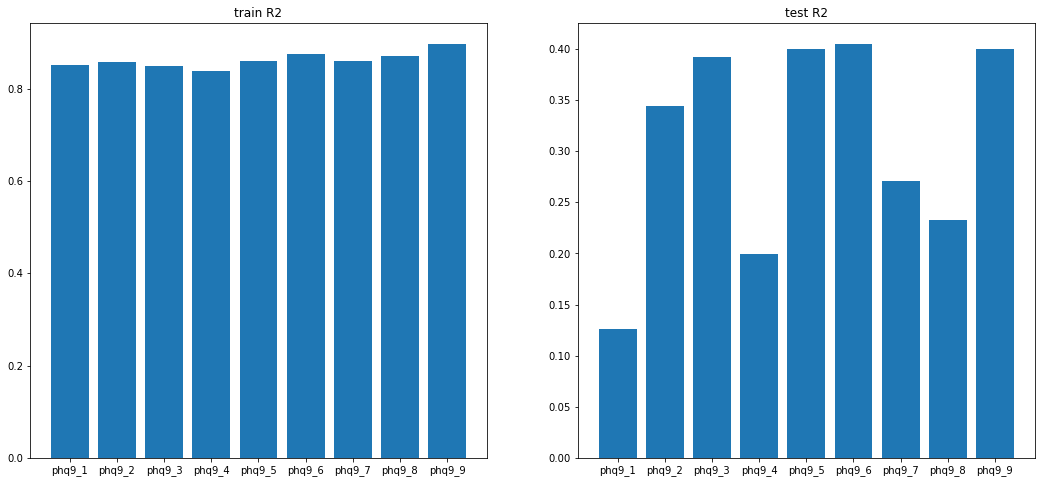

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax= plt.subplots(1,2,figsize=(18, 8))

# ax[0].set_title('Insert Title Here')

ax[0].bar(target_list, train_scores)
ax[0].set_title('train R2')
ax[1].bar(target_list, test_scores)
ax[1].set_title('test R2')


### 3.target = phq2 (sum or each question)
we got more training samples than phq9, but the X is more sparse than phq9.

In [83]:
phq2

,participant_id,date,target
0,EN00035,2016-09-12,3.0
1,EN00035,2016-09-13,2.0
2,EN00036,2016-09-13,8.0
3,EN00039,2016-09-14,5.0
4,EN00039,2016-09-18,8.0
...,...,...,...
8169,ES05073,2017-03-06,2.0
8170,ES05073,2017-03-09,2.0
8171,ES05073,2017-03-11,6.0
8172,ES05073,2017-03-14,2.0


In [15]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['phq2_1', 'phq2_2', 'phq2_sum']

phq2_index_list = [1,2,0]
train_scores = []
test_scores = []


for target_name, phq2_index in zip(target_list, phq2_index_list):
    print('target:', target_name)
    phq2 = dp.load_phq2_targets(DATADIR / 'df_phq2_v2.csv', type=TYPE, target='value', phq2_index= phq2_index)
    combined = dp.combine(phq2, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

target: phq2_1
Train set shape: (6947, 42)
Test set shape: (1227, 42)

Train set RMSE: 0.6492
Test set RMSE:  0.9808
Train score: 0.7184329512354508
Test score: 0.33091455199930975
target: phq2_2
Train set shape: (6947, 42)
Test set shape: (1227, 42)

Train set RMSE: 0.6759
Test set RMSE:  1.0259
Train score: 0.697596793730682
Test score: 0.28861924802643
target: phq2_sum
Train set shape: (6947, 42)
Test set shape: (1227, 42)

Train set RMSE: 1.1985
Test set RMSE:  1.7839
Train score: 0.7241932233637749
Test score: 0.36690118829139307


Text(0.5, 1.0, 'test R2')

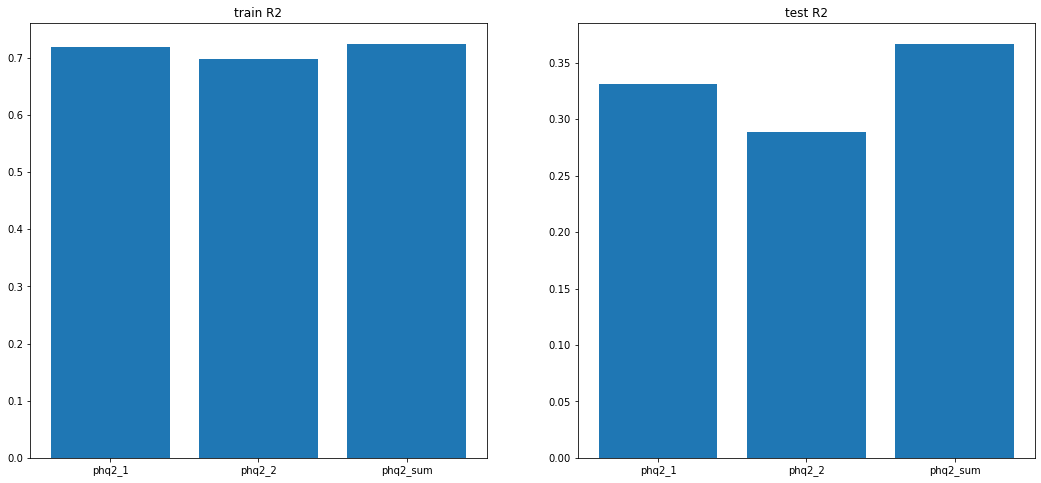

In [16]:
fig, ax= plt.subplots(1,2,figsize=(18, 8))

# ax[0].set_title('Insert Title Here')

ax[0].bar(target_list, train_scores)
ax[0].set_title('train R2')
ax[1].bar(target_list, test_scores)
ax[1].set_title('test R2')

In [10]:
phq9.participant_id.unique().size
# combined.participant_id.unique().size
# locations.participant_id.unique().size
locations

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work,has_locations
0,EN00039,2016-09-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,EN00039,2016-09-17,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,EN00039,2016-11-11,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,EN00039,2016-11-13,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,EN00039,2016-11-14,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10422,ES05073,2017-03-16,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
10423,ES05073,2017-03-17,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
10424,ES05073,2017-03-18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
10425,ES05073,2017-03-20,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


## RandomForest tuning

In [32]:
#training set 
df_training = combined.drop(combined.columns.intersection(['target', 'participant_id', 'date']), axis=1)

In [33]:

model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=SEED)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 433,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 800, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
max_samples =  [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
criterion = ['squared_error', 'absolute_error', 'poisson','MAE']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples':max_samples
            #    'bootstrap': bootstrap
               }
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_samples': [0.1,
                 0.2,
                 0.30000000000000004,
                 0.4,
                 0.5,
                 0.6,
                 0.7000000000000001,
                 0.8,
                 0.9,
                 1.0],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400,
                  421,
                  442,
                  463,
                  484,
                  505,
                  526,
                  547,
                  568,
                  589,
                  610,
                  631,
                  652,
                  673,
                  694,
                  715,
                  736,
                  757,
                  778,
                  800]}


In [35]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value', sum_phq9 = True, phq9_index= 0)
combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined = dp.rf_preprocess(combined)

sum_phq9


In [37]:
SEED = 433
x, y = dp.xy_split(combined)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)
print('Train set shape:', x_train.shape)
print('Test set shape:', x_test.shape)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Train set shape: (986, 42)
Test set shape: (175, 42)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=110, max_features=log2, max_samples=0.4, min_samples_leaf=4, min_samples_split=2, n_estimators=505; total time=   0.6s
[CV] END max_depth=110, max_features=log2, max_samples=0.4, min_samples_leaf=4, min_samples_split=2, n_estimators=505; total time=   0.7s
[CV] END max_depth=80, max_features=sqrt, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=2, n_estimators=694; total time=   0.9s
[CV] END max_depth=80, max_features=sqrt, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=2, n_estimators=694; total time=   1.0s
[CV] END max_depth=80, max_features=sqrt, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=2, n_estimators=694; total time=   1.0s
[CV] END max_depth=10, max_features=log2, max_samples=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.0s
[CV] END max

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=10, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=757; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=757; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=757; total time=   0.8s
[CV] END max_depth=100, max_features=auto, max_samples=0.30000000000000004, min_samples_leaf=2, min_samples_split=5, n_estimators=421; total time=   0.6s
[CV] END max_depth=None, max_features=auto, max_samples=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=547; total time=   1.4s
[CV] END max_depth=None, max_features=auto, max_samples=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=547; total time=   1.5s
[CV] END max_depth=60, max_features=sqrt, max_samples=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=463; total time=   0.0s
[CV] END max_depth=6

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=30, max_features=auto, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=10, n_estimators=778; total time=   1.6s
[CV] END max_depth=20, max_features=auto, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=673; total time=   1.9s
[CV] END max_depth=20, max_features=auto, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=673; total time=   1.9s
[CV] END max_depth=20, max_features=auto, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=673; total time=   1.9s
[CV] END max_depth=30, max_features=auto, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=10, n_estimators=778; total time=   1.6s
[CV] END max_depth=30, max_features=auto, max_samples=0.30000000000000004, min_samples_leaf=4, min_samples_split=10, n_estimators=778; total time=   1.1s
[CV] END max_depth=50, max_features=auto, max_samples=0.8, min_samples_leaf=4, min_samples_split=10, n_estimators=568; total ti

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=421; total time=   1.1s
[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=421; total time=   1.1s
[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=421; total time=   1.1s
[CV] END max_depth=40, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=694; total time=   1.6s
[CV] END max_depth=40, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=694; total time=   1.6s
[CV] END max_depth=40, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=694; total time=   1.7s
[CV] END max_depth=100, max_features=log2, max_samples=0.2, min_samples_leaf=2, min_samples_split=10, n_estimators=526; total time=   0.5s
[CV] END max_depth=100, max_featu

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=30, max_features=log2, max_samples=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=484; total time=   0.0s
[CV] END max_depth=30, max_features=log2, max_samples=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=484; total time=   0.0s
[CV] END max_depth=30, max_features=log2, max_samples=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=484; total time=   0.0s
[CV] END max_depth=80, max_features=sqrt, max_samples=0.4, min_samples_leaf=2, min_samples_split=10, n_estimators=589; total time=   0.7s
[CV] END max_depth=None, max_features=log2, max_samples=0.7000000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=442; total time=   0.5s
[CV] END max_depth=None, max_features=log2, max_samples=0.7000000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=442; total time=   0.4s
[CV] END max_depth=None, max_features=log2, max_samples=0.7000000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=442; total

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=20, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=5, n_estimators=631; total time=   0.8s
[CV] END max_depth=20, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=5, n_estimators=631; total time=   0.8s
[CV] END max_depth=20, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=5, n_estimators=631; total time=   0.8s
[CV] END max_depth=30, max_features=auto, max_samples=0.2, min_samples_leaf=4, min_samples_split=10, n_estimators=526; total time=   0.5s
[CV] END max_depth=110, max_features=auto, max_samples=0.2, min_samples_leaf=2, min_samples_split=10, n_estimators=631; total time=   0.8s
[CV] END max_depth=30, max_features=auto, max_samples=0.2, min_samples_leaf=4, min_samples_split=10, n_estimators=526; total time=   0.7s
[CV] END max_depth=110, max_features=auto, max_samples=0.2, min_samples_leaf=2, min_samples_split=10, n_estimators=631; total time=   0.8s
[CV] END max_depth=110, max_feature

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=568; total time=   1.2s
[CV] END max_depth=40, max_features=auto, max_samples=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=694; total time=   0.0s
[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=568; total time=   1.4s
[CV] END max_depth=30, max_features=log2, max_samples=0.6, min_samples_leaf=4, min_samples_split=2, n_estimators=547; total time=   0.7s
[CV] END max_depth=40, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=421; total time=   0.8s
[CV] END max_depth=70, max_features=auto, max_samples=0.6, min_samples_leaf=2, min_samples_split=5, n_estimators=568; total time=   1.5s
[CV] END max_depth=30, max_features=log2, max_samples=0.6, min_samples_leaf=4, min_samples_split=2, n_estimators=547; total time=   0.7s
[CV] END max_depth=60, max_features=log2,

/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END max_depth=60, max_features=log2, max_samples=0.9, min_samples_leaf=1, min_samples_split=5, n_estimators=526; total time=   0.5s
[CV] END max_depth=60, max_features=log2, max_samples=0.9, min_samples_leaf=1, min_samples_split=5, n_estimators=526; total time=   0.5s
[CV] END max_depth=60, max_features=log2, max_samples=0.9, min_samples_leaf=1, min_samples_split=5, n_estimators=526; total time=   0.5s
[CV] END max_depth=90, max_features=auto, max_samples=0.9, min_samples_leaf=1, min_samples_split=10, n_estimators=568; total time=   1.1s
[CV] END max_depth=90, max_features=auto, max_samples=0.9, min_samples_leaf=1, min_samples_split=10, n_estimators=568; total time=   1.1s
[CV] END max_depth=90, max_features=auto, max_samples=0.9, min_samples_leaf=1, min_samples_split=10, n_estimators=568; total time=   1.2s


/Users/siyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.22181551 0.17011455 0.22916433 0.22851138 0.38880145 0.39737442
 0.21297644 0.38191475 0.33954293 0.36776504 0.4045193         nan
 0.42500127 0.30671992        nan        nan 0.40979151 0.31286018
 0.37407982 0.39673629 0.31417877 0.38118101 0.19860706 0.27208405
 0.28841813 0.43947614 0.26295763 0.45359732 0.27182005 0.31736168
 0.37164307 0.38314954 0.29997758 0.33879997 0.35314312 0.34044257
 0.27399922 0.49846273 0.4629534  0.35775276 0.27651792 0.38509434
 0.18065002 0.46009563 0.42308608 0.40213687 0.40088535 0.40191905
        nan 0.46503859 0.19890723 0.33873155 0.20679407 0.45543082
 0.38643503 0.2182647  0.31582916 0.26256855 0.28667425 0.48622052
 0.28171259        nan 0.30430604 0.48585148 0.27402426 0.24714057
 0.39800206 0.27119776        nan 0.26189014 0.40152147 0.42271435
 0.30741328 0.3573445  0.36740311 0.123986

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': [0.1, 0.2,
                                                        0.30000000000000004,
                                                        0.4, 0.5, 0.6,
                                                        0.7000000000000001, 0.8,
                                                        0.9, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                      

In [38]:
rf_random.best_params_

{'n_estimators': 694,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.9,
 'max_features': 'log2',
 'max_depth': 20}

In [39]:
model = RandomForestRegressor(n_estimators= 700,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features = 'log2',
 max_samples = 0.9,
 max_depth =20)
 
model.fit(x_train, y_train)
print(f'Train score:', model.score(x_train, y_train)) 
print(f'Test score:', model.score(x_test, y_test)) 

# print('feature sorted by importances')
# df_training.columns[(model.feature_importances_).argsort()[::-1][:20]]

Train score: 0.8850559772746741
Test score: 0.4940504180321179


#### Random Forest Trial

In [20]:
combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined.columns

Index(['participant_id', 'target', 'has_phq9', 'automotive', 'consumer_goods',
       'dining_out', 'education', 'entertainment', 'finance',
       'government_offices', 'health', 'home', 'home_store', 'lodging', 'park',
       'personal_services', 'place_of_mourning', 'place_of_worship', 'repair',
       'supermarket', 'transit', 'work', 'has_locations', 'working',
       'income_satisfaction', 'income_lastyear', 'age', 'gen_Female',
       'gen_Male', 'martial_Married/Partner',
       'martial_Separated/Widowed/Divorced', 'martial_Single',
       'edu_Community College', 'edu_Elementary School', 'edu_Graduate Degree',
       'edu_High School', 'edu_None', 'edu_University',
       'race_African-American/Black', 'race_American Indian/Alaskan Native',
       'race_Asian', 'race_Hispanic/Latino', 'race_More than one',
       'race_Native Hawaiian/other Pacific Islander',
       'race_Non-Hispanic White', 'race_Other'],
      dtype='object')

In [21]:
combined
# combined.loc[:, 'automotive':'work'] 

,participant_id,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,2.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,4.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,17.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,ES05073,13.0,0.076923,0.0,0.0,0.000801,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1157,ES05073,12.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1158,ES05073,3.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1159,ES05073,21.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [23]:
combined


,participant_id,target,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,4.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,17.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,ES05073,13.0,0.0,0.0,0.000801,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1157,ES05073,12.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1158,ES05073,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1159,ES05073,21.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


RandomForestRegressor(n_estimators=50, n_jobs=-1)

1.976435548356943 4.160818012698526


We need some kind of hand-made context. Since we're just focusing on dates actually having PHQ9 scores, how about averaging out the location features since the last phq9 to use as context for the current PHQ9? For each participant, of course.

In [75]:
# There's probably a faster pure pandas method, but whatever!
participants = daily.participant_id.unique()
out_rows = []

participants = ['EN00041']
for participant in participants:
    prows = daily[daily.participant_id == participant]
    if len(prows) == 1: # skip if there is no data
        continue
    prows
    break
prows

,Unnamed: 0,participant_id,week,sum_phq9,date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,...,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work,has_location
4180,4180.0,EN00041,1.0,9.0,2016-08-19,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4152,4152.0,EN00041,3.0,6.0,2016-09-02,1.0,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3723,3723.0,EN00041,4.0,5.0,2016-09-09,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4839,NaN,EN00041,NaN,NaN,2016-09-12,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4840,NaN,EN00041,NaN,NaN,2016-09-15,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4413,4413.0,EN00041,5.0,4.0,2016-09-16,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4841,NaN,EN00041,NaN,NaN,2016-09-17,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4842,NaN,EN00041,NaN,NaN,2016-09-18,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4843,NaN,EN00041,NaN,NaN,2016-09-19,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4844,NaN,EN00041,NaN,NaN,2016-09-20,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [73]:
daily[daily['has_location'].notna()]
p = daily[daily['has_location'].notna()].participant_id.unique()
p

array(['EN00039', 'EN00041', 'EN00046', 'EN00047', 'EN00052', 'EN00055',
       'EN00056', 'EN00057', 'EN00060', 'EN00061', 'EN00064', 'EN00065',
       'EN00067', 'EN00068', 'EN00071', 'EN00073', 'EN00076', 'EN00077',
       'EN00080', 'EN00082', 'EN00083', 'EN00084', 'EN00088', 'EN00089',
       'EN00091', 'EN00101', 'EN00102', 'EN00106', 'EN00111', 'EN00124',
       'EN00125', 'EN00127', 'EN00129', 'EN00130', 'EN00132', 'EN00136',
       'EN00138', 'EN00142', 'EN00145', 'EN00147', 'EN00150', 'EN00152',
       'EN00155', 'EN00156', 'EN00164', 'EN00168', 'EN00171', 'EN00178',
       'EN00181', 'EN00185', 'EN00192', 'EN00194', 'EN00196', 'EN00198',
       'EN00208', 'EN00218', 'EN00219', 'EN00221', 'EN00225', 'EN00228',
       'EN00229', 'EN00231', 'EN00232', 'EN00243', 'EN00249', 'EN00250',
       'EN00251', 'EN00252', 'EN00262', 'EN00263', 'EN00272', 'EN00275',
       'EN00276', 'EN00281', 'EN00285', 'EN00295', 'EN00301', 'EN00309',
       'EN00313', 'EN00319', 'EN00322', 'EN00325', 

In [210]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET, sum_phq9 = True, phq9_index= 0)
# s = phq9.loc[:, 'phq9_1':'phq9_9'].sum(axis=1)

sum_phq9


In [ ]:
combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined = dp.rf_preprocess(combined)

In [ ]:
group_and_reduce_phq9()

In [305]:
def group_and_reduce_phq9(df, method='mean'):
    inds = group_by_phq9(df)
    # method = ['mean','std']
    mean_df = df.groupby(inds).agg('mean').add_prefix('mean_').reset_index()
    mean_df.rename(columns = {'mean_target':'target', 'mean_has_phq9':'has_phq9'},inplace = True)
    std_df = df.groupby(inds).agg('std').add_prefix('std_').reset_index()
    std_df.rename(columns = {'std_target':'target','std_has_phq9':'has_phq9'},inplace = True)
    mean_df.merge(std_df, how = 'inner')
    # return mean_df.merge(std_df, how = 'inner')
    # return std_df
    return df.groupby(inds).agg('mean').reset_index()
    return mean_df

def group_by_phq9(df):
    # Assign a different group number to each consecutive phq9 'block'
    c = 0
    groups = []
    # Probably can derive this from some kind of cumsum, but brain is offline atm
    for k in df.has_phq9:
        groups.append(c)
        if k:
            c += 1
    return groups

In [306]:
std_df = pgrp.apply(group_and_reduce_phq9)


In [307]:
std_df

index  target  has_phq9  automotive  consumer_goods  \
participant_id                                                          
BLUE-00048     0      0     7.0       1.0         NaN             NaN   
BLUE-00050     0      0     7.0       1.0         NaN             NaN   
               1      1     4.0       1.0         NaN             NaN   
               2      2     5.0       1.0         NaN             NaN   
               3      3     5.0       1.0         NaN             NaN   
...                 ...     ...       ...         ...             ...   
YELLOW-00262   2      2    10.0       1.0         NaN             NaN   
YELLOW-00263   0      0    12.0       1.0         NaN             NaN   
               1      1     8.0       1.0         NaN             NaN   
               2      2     9.0       1.0         NaN             NaN   
               3      3    10.0       1.0         NaN             NaN   

                  dining_out  education  entertainment  finance  \
participant_id                                                    
BLUE-00048     0         NaN        NaN            NaN      NaN   
BLUE-00050     0         NaN        NaN            NaN      NaN   
               1         NaN        NaN            NaN      NaN   
               2         NaN        NaN            NaN      NaN   
               3         NaN        NaN            NaN      NaN   
...                      ...        ...            ...      ...   
YELLOW-00262   2         NaN        NaN            NaN      NaN   
YELLOW-00263   0         NaN        NaN            NaN      NaN   
               1         NaN        NaN            NaN      NaN   
               2         NaN        NaN            NaN      NaN   
               3         NaN        NaN            NaN      NaN   

                  government_offices  ...  lodging  park  personal_services  \
participant_id                        ...                                     
BLUE-00048     0                 NaN  ...      NaN   NaN                NaN   
BLUE-00050     0                 NaN  ...      NaN   NaN                NaN   
               1                 NaN  ...      NaN   NaN                NaN   
               2                 NaN  ...      NaN   NaN                NaN   
               3                 NaN  ...      NaN   NaN                NaN   
...                              ...  ...      ...   ...                ...   
YELLOW-00262   2                 NaN  ...      NaN   NaN                NaN   
YELLOW-00263   0                 NaN  ...      NaN   NaN                NaN   
               1                 NaN  ...      NaN   NaN                NaN   
               2                 NaN  ...      NaN   NaN                NaN   
               3                 NaN  ...      NaN   NaN                NaN   

                  place_of_mourning  place_of_worship  repair  supermarket  \
participant_id                                                               
BLUE-00048     0                NaN               NaN     NaN          NaN   
BLUE-00050     0                NaN               NaN     NaN          NaN   
               1                NaN               NaN     NaN          NaN   
               2                NaN               NaN     NaN          NaN   
               3                NaN               NaN     NaN          NaN   
...                             ...               ...     ...          ...   
YELLOW-00262   2                NaN               NaN     NaN          NaN   
YELLOW-00263   0                NaN               NaN     NaN          NaN   
               1                NaN               NaN     NaN          NaN   
               2                NaN               NaN     NaN          NaN   
               3                NaN               NaN     NaN          NaN   

                  transit  work  has_locations  
participant_id                                  
BLUE-00048     0      NaN   NaN            0.0  
BLUE-0

In [298]:
mean_df

index  target  has_phq9  mean_automotive  \
participant_id                                               
BLUE-00048     0      0     7.0       1.0              NaN   
BLUE-00050     0      0     7.0       1.0              NaN   
               1      1     4.0       1.0              NaN   
               2      2     5.0       1.0              NaN   
               3      3     5.0       1.0              NaN   
...                 ...     ...       ...              ...   
YELLOW-00262   2      2    10.0       1.0              NaN   
YELLOW-00263   0      0    12.0       1.0              NaN   
               1      1     8.0       1.0              NaN   
               2      2     9.0       1.0              NaN   
               3      3    10.0       1.0              NaN   

                  mean_consumer_goods  mean_dining_out  mean_education  \
participant_id                                                           
BLUE-00048     0                  NaN              NaN             NaN   
BLUE-00050     0                  NaN              NaN             NaN   
               1                  NaN              NaN             NaN   
               2                  NaN              NaN             NaN   
               3                  NaN              NaN             NaN   
...                               ...              ...             ...   
YELLOW-00262   2                  NaN              NaN             NaN   
YELLOW-00263   0                  NaN              NaN             NaN   
               1                  NaN              NaN             NaN   
               2                  NaN              NaN             NaN   
               3                  NaN              NaN             NaN   

                  mean_entertainment  mean_finance  mean_government_offices  \
participant_id                                                                
BLUE-00048     0                 NaN           NaN                      NaN   
BLUE-00050     0                 NaN           NaN                      NaN   
               1                 NaN           NaN                      NaN   
               2                 NaN           NaN                      NaN   
               3                 NaN           NaN                      NaN   
...                              ...           ...                      ...   
YELLOW-00262   2                 NaN           NaN                      NaN   
YELLOW-00263   0                 NaN           NaN                      NaN   
               1                 NaN           NaN                      NaN   
               2                 NaN           NaN                      NaN   
               3                 NaN           NaN                      NaN   

                  ...  mean_lodging  mean_park  mean_personal_services  \
participant_id    ...                                                    
BLUE-00048     0  ...           NaN        NaN                     NaN   
BLUE-00050     0  ...           NaN        NaN                     NaN   
               1  ...           NaN        NaN                     NaN   
               2  ...           NaN        NaN                     NaN   
               3  ...           NaN        NaN                     NaN   
...               ...           ...        ...                     ...   
YELLOW-00262   2  ...           NaN        NaN                     NaN   
YELLOW-00263   0  ...           NaN        NaN                     NaN   
               1  ...           NaN        NaN                     NaN   
               2  ...           NaN        NaN                     NaN   
               3  ...           NaN        NaN                     NaN   

                  mean_place_of_mourning  mean_place_of_worship  mean_repair  \
participant_id                                                                 
BLUE-00048     0                     NaN                    NaN          NaN   
BLUE-00050     0 

In [263]:
combined['target'].unique()

array([ 1.,  2.,  4., 17., 16., 15., 23., 14.,  9.,  6.,  5.,  3., 12.,
        8., 10., 19.,  7., 18., 11., 13., 24., 20.,  0., 21., 22., 27.,
       26., 25.])

In [260]:
daily_rows.drop('has_phq9', axis =1)
# daily_rows

,index,target,mean_automotive,mean_consumer_goods,mean_dining_out,mean_education,mean_entertainment,mean_finance,mean_government_offices,mean_health,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other


In [264]:


daily_reduction='mean'
dailies=[('locations', locations)]
constants=[demographics]

# Remember that PHQ9 is also daily.
# Dailies should be (name, csv) pairs.

# Also, let's add an extra column has_* to check for daily attributes later
has_keys = ['has_phq9']
phq9['has_phq9'] = True

for name, csv in dailies:
    k = f'has_{name}'
    csv[k] = True
    has_keys.append(k)

# Now, merge everything. Use an 'outer' merge so that all entries are included,
# and those who don't exist for that date get NaNs
daily_merged = phq9
for name, csv in dailies:
    daily_merged = daily_merged.merge(csv, on=['participant_id', 'date'], how='outer')
daily_merged.sort_values(by=['participant_id', 'date'], inplace=True)

# To make things look a bit cleaner, replace NaN with False for has_* columns
for has_key in has_keys:
    daily_merged[has_key].fillna(False, inplace=True)

# Now we need to do the reduction. Now, I'm sure there is some sort of
# .groupby() magic that can handle this, but I'll do it the lazy way for now.
pgrp = daily_merged.groupby('participant_id')

daily_rows = pgrp.apply(group_and_reduce_phq9)


# Need to post_process the daily_rows a bit

# 1. daily_rows has all the aggregated data we want, and each rows should have
# a phq9 score. However, there is a possible issue: trailing location data
# with no final phq9, which would lead to an empty group. We can remove such rows
# easily by checking has_phq9, which should be 0 since no phq9 was aggregated.
daily_rows = daily_rows[daily_rows.has_phq9 > 0.0]

# 2. Replace NaN values with 0. Not great, but oh well...
daily_rows.fillna(0.0, inplace=True)

# Now, append the constants to each row
for const in constants:
    daily_rows = daily_rows.merge(const, on='participant_id')


  

In [272]:
daily_merged

,participant_id,target,date,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work,has_locations
0,BLUE-00048,7.0,2014-08-08,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,BLUE-00050,7.0,2014-08-23,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,BLUE-00050,4.0,2014-08-30,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,BLUE-00050,5.0,2014-09-08,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,BLUE-00050,5.0,2014-09-22,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,10.0,2014-12-31,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3623,YELLOW-00263,12.0,2014-12-17,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3624,YELLOW-00263,8.0,2014-12-24,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3625,YELLOW-00263,9.0,2014-12-31,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [253]:
def _group_and_reduce_phq9(df, method=['mean', 'std']):
    from collections.abc import Sequence
    import functools
    inds = _group_by_phq9(df)
    if isinstance(method, Sequence):
        lst = []
        for m in method:
            f = df.groupby(inds).agg(m)
            f.rename(columns={col: col + f'_{m}' for col in f.columns}, inplace=True)
            lst.append(f)
        return functools.reduce(lambda x, y: x.join(y), lst)
    else:
        return df.groupby(inds).agg(method)


,index,target,has_phq9,mean_automotive,mean_consumer_goods,mean_dining_out,mean_education,mean_entertainment,mean_finance,mean_government_offices,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
